In [1]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


/home/pricie/frederic/name_clustering_transformer/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../utils')
import databalancing
import gpu_manager
from logger import Logger

In [3]:
log = Logger(base_dir= '../')
log.log('[INFO]: Reporting script launched')
gpu_manager.pick_gpu(1, 'auto', 1)

[INFO] Found 3 free GPUs: [0, 2, 3]
[INFO] Using GPUs: [0]


In [4]:
# 1. Load test dataset
df = pd.read_csv("../data/studium_name_pairs_testdata.csv")
df = df.drop_duplicates()


In [5]:
pos_false_ratio = 15   #for every POS case, how many false pairs are there? 
log.log(f'[INFO]: True-to-False ratio: 1 - {pos_false_ratio}')


In [6]:
#the dataset is really big to run against all possible models, let's take all the true pairs and 3 false pairs per true pair. 
df_true = df.loc[df.are_same==1]
df_false = df.loc[df.are_same==0].sample(pos_false_ratio*len(df_true))
df_studium = pd.concat([df_true, df_false], ignore_index=True, sort=False)

In [7]:
df_studium =  df_studium.sample(frac=1)
df_studium

,name1,name2,are_same
204932,Frank,Hyacynthus,0
53018,L̕udovít,Felix,0
306089,Gionisius,Léger,0
314071,Helyas,Blas,0
288981,Atilius,Humannus,0
...,...,...,...
145278,Michał,Gabriël,0
151625,J.T.P.,Maccharius,0
258633,Isibrandus,Roderick,0
166800,Patricus,Lambertis,0


In [8]:
log.log(f'[INFO]: created dataset with {len(df_studium)} samples.')


In [9]:
# 2. Metrics
def ez_metrics(labels, preds):
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
    }


In [10]:
# 3. Dataset class (same as training)
class NamePairDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text1, text2, label = str(row.name1), str(row.name2), int(row.are_same)
        encoding = self.tokenizer(
            text1,
            text2,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long),
        }


In [11]:

# 4. Prepare labels
actuals = df_studium["are_same"].tolist()


In [12]:

# 5. Random baseline
randoguess = np.random.randint(0, 2, (len(actuals),))
report = {"random_guessing": ez_metrics(actuals, randoguess)}


In [13]:

# 6. Evaluate each trained model
trained_models_dir = "../completed_experiments"

for experiment in os.listdir(trained_models_dir):
    subdir = os.path.join(trained_models_dir, experiment)
    if not os.path.isdir(subdir):
        continue

    print(f"Evaluating {experiment}...")
    log.log(f'[INFO]: evaluating {experiment}...')


    # Load tokenizer + model
    tokenizer = AutoTokenizer.from_pretrained(subdir)
    model = AutoModelForSequenceClassification.from_pretrained(subdir)

    # Wrap in trainer for convenience
    test_dataset = NamePairDataset(df_studium, tokenizer)
    trainer = Trainer(model=model, tokenizer=tokenizer)

    # Predictions
    preds = trainer.predict(test_dataset)
    y_pred = np.argmax(preds.predictions, axis=-1)

    # Store metrics
    loopresults = ez_metrics(actuals, y_pred)
    report[experiment] = loopresults
    log.log(message = f'[REPORT]: results of experiment {experiment}: ', object = loopresults)



Evaluating paraphrase-multilingual-mpnet-base-v2_balanced...


/tmp/ipykernel_2089312/4061084123.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Evaluating paraphrase-multilingual-mpnet-base-v2_unbalanced...


/tmp/ipykernel_2089312/4061084123.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Evaluating paraphrase-multilingual-MiniLM-L12-v2_balanced...


/tmp/ipykernel_2089312/4061084123.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Evaluating paraphrase-multilingual-MiniLM-L12-v2_unbalanced...


/tmp/ipykernel_2089312/4061084123.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Evaluating LaBSE_balanced...


/tmp/ipykernel_2089312/4061084123.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Evaluating LaBSE_unbalanced...


/tmp/ipykernel_2089312/4061084123.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Evaluating xlm-roberta-base_balanced...


/tmp/ipykernel_2089312/4061084123.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


Evaluating xlm-roberta-base_unbalanced...


/tmp/ipykernel_2089312/4061084123.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


In [14]:

# 7. Convert results to DataFrame
results_df = pd.DataFrame(report).T.reset_index().rename(columns={"index": "model"})

print(results_df)

log.log(message = f"Experiment overview: ", object = results_df)



                                              model  accuracy  precision  \
0                                   random_guessing  0.499746   0.062461   
1    paraphrase-multilingual-mpnet-base-v2_balanced  0.933200   0.481434   
2  paraphrase-multilingual-mpnet-base-v2_unbalanced  0.135954   0.067347   
3    paraphrase-multilingual-MiniLM-L12-v2_balanced  0.888809   0.334172   
4  paraphrase-multilingual-MiniLM-L12-v2_unbalanced  0.093740   0.064340   
5                                    LaBSE_balanced  0.966321   0.668788   
6                                  LaBSE_unbalanced  0.892188   0.361608   
7                         xlm-roberta-base_balanced  0.062500   0.062500   
8                       xlm-roberta-base_unbalanced  0.530516   0.114372   

     recall        f1  
0  0.499929  0.111047  
1  0.892029  0.625358  
2  0.998157  0.126181  
3  0.784955  0.468776  
4  0.996881  0.120879  
5  0.913576  0.772248  
6  0.947172  0.523395  
7  1.000000  0.117647  
8  0.965648  0.204521  

/tmp/ipykernel_2089312/1881594974.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_2089312/1881594974.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_2089312/1881594974.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_2089312/1881594974.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")


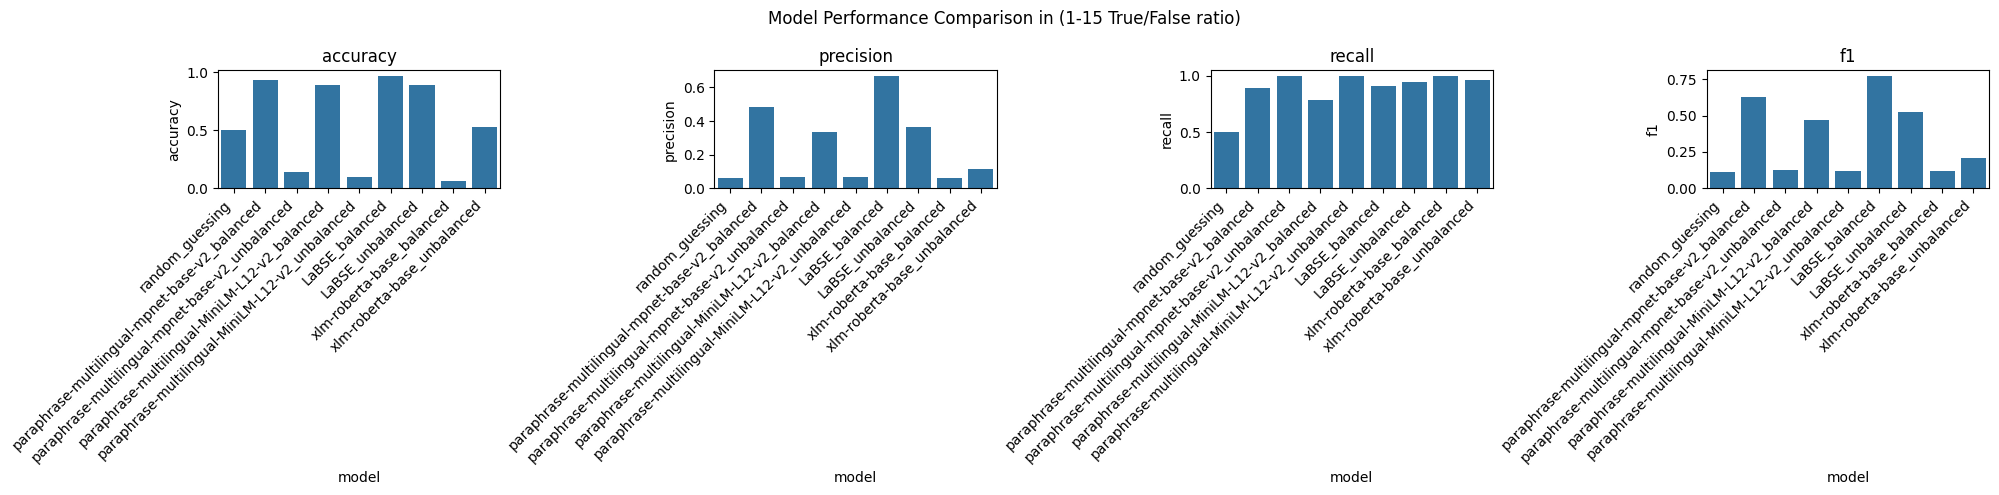

In [15]:

# 8. Visualization - barplot per metric
metrics = ["accuracy", "precision", "recall", "f1"]

fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(metrics):
    sns.barplot(data=results_df, x="model", y=metric, ax=axes[i])
    axes[i].set_title(metric)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

plt.suptitle(f"Model Performance Comparison in (1-{pos_false_ratio} True/False ratio)")
plt.tight_layout()
plt.savefig(f"../viz_output/1-{pos_false_ratio} compare metrics.png", bbox_inches='tight')
plt.show()


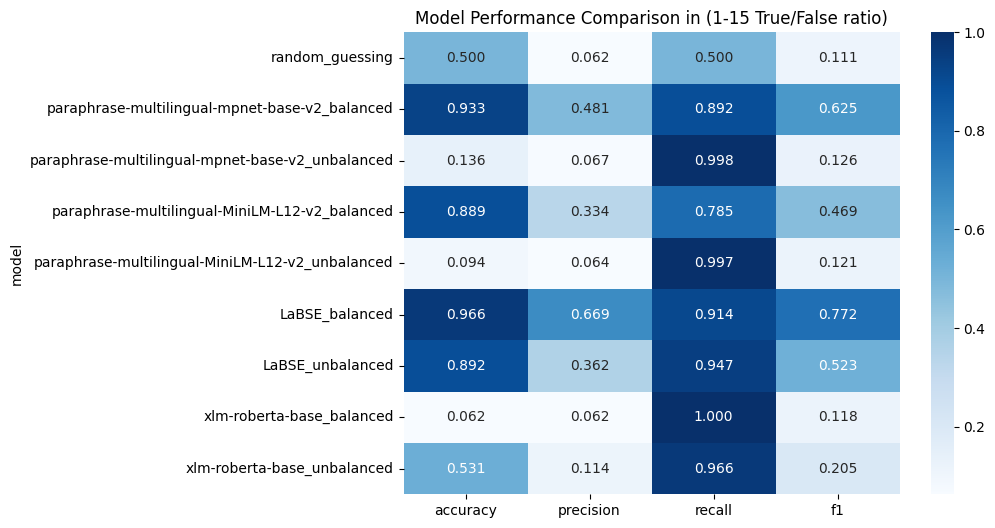

In [16]:
# 9. Heatmap comparison
plt.figure(figsize=(8,6))
sns.heatmap(results_df.set_index("model")[metrics], annot=True, fmt=".3f", cmap="Blues")
plt.title(f"Model Performance Comparison in (1-{pos_false_ratio} True/False ratio)")
plt.savefig(f"../viz_output/1-{pos_false_ratio} heatmap.png", bbox_inches='tight')
plt.show()
